In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model, metrics
from sklearn.cross_validation import KFold

from matplotlib import rcParams
#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (3, 2)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'
rcParams['agg.path.chunksize'] = 10000

C:\Users\jatin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jatin\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Reading datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv("Sample_Submission.csv")

In [4]:
# Step 1 - Exploratory Data Analysis

In [5]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


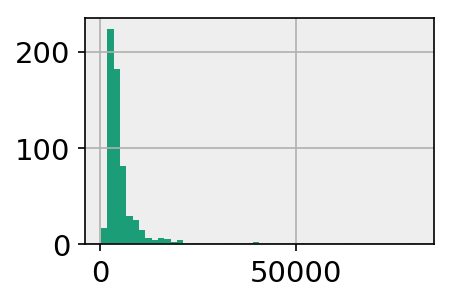

In [7]:
train['ApplicantIncome'].hist(bins=50)

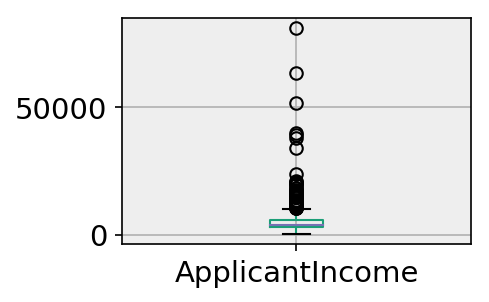

In [8]:
train.boxplot(column='ApplicantIncome')

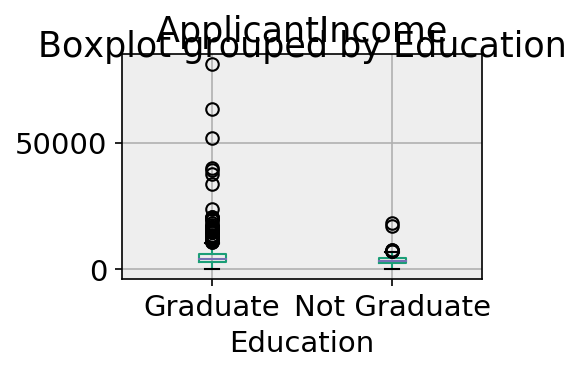

In [9]:
train.boxplot(column='ApplicantIncome', by = 'Education')

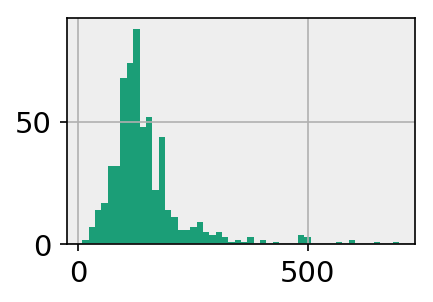

In [10]:
train['LoanAmount'].hist(bins=50)

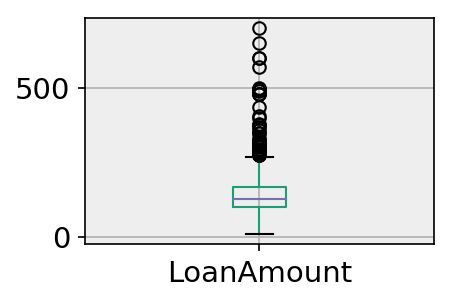

In [11]:
train.boxplot(column='LoanAmount')

In [12]:
## From above analysis, we can conclude two things -
## 1 - ApplicantIncome has outliers
## 2 - LoanAmount has outliers and missing values

In [13]:
## Categorical variable analysis - 

In [14]:
temp1 = train['Credit_History'].value_counts()
temp2 = train.pivot_table(values='Loan_Status', index='Credit_History', aggfunc=lambda x : x.map({'Y':1, 'N':0}).mean())

In [15]:
temp1

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [16]:
print("Probability of getting Loan by Credit History")
temp2

Probability of getting Loan by Credit History


Credit_History
0.0    0.078652
1.0    0.795789
Name: Loan_Status, dtype: float64

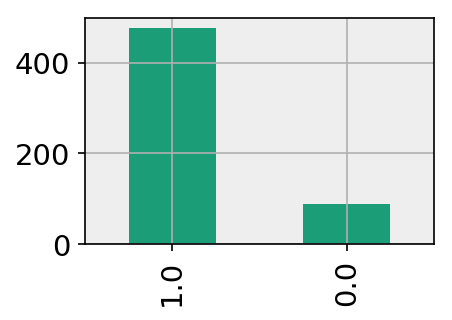

In [17]:
temp1.plot(kind='bar')

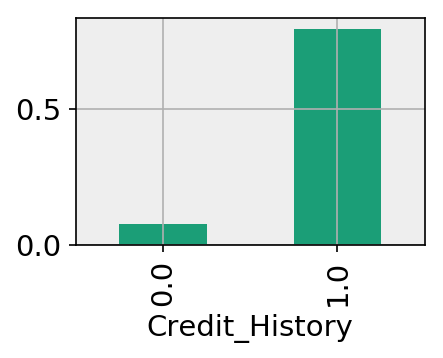

In [18]:
temp2.plot(kind='bar')

In [19]:
## This proves that Chances of getting a Loan is 8 fold if you have Valid Credit History

In [20]:
## Step 2 - Data Munging

In [21]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [22]:
train['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [23]:
# Since ~86% values are “No”, it is safe to impute the missing values as “No” as there is a high probability of success

In [24]:
train['Self_Employed'].fillna('No',inplace=True)
test['Self_Employed'].fillna('No',inplace=True)

In [25]:
## Since "Loan Amount" can vary depending on a person's "Education" and "Self_Employed" factor.
## We will impute the missing values of Loan Amount by the  median values for all the groups of 
## unique values of Self_Employed and Education features

In [26]:
table = train.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [27]:
def get_train_loan_amount(x):
    return table.loc[x['Self_Employed'],x['Education']]

In [28]:
# Replace missing values
train['LoanAmount'].fillna(train[train['LoanAmount'].isnull()].apply(get_train_loan_amount, axis=1), inplace=True)

In [29]:
## Repeating this for test data
test_table = test.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
test_table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,120.0
Yes,137.0,119.0


In [30]:
def get_test_loan_amount(x):
    return test_table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
test['LoanAmount'].fillna(test[test['LoanAmount'].isnull()].apply(get_test_loan_amount, axis=1), inplace=True)


In [31]:
## Treating Extreme values (Outliers) in "LoanAmount" and "ApplicantIncome"
# Let’s analyze LoanAmount first. Since the extreme values are practically possible, 
# i.e. some people might apply for high value loans due to specific needs. 
# So instead of treating them as outliers, let’s try a log transformation to nullify their effect:

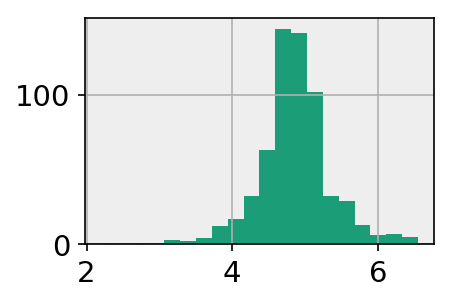

In [32]:
train['LoanAmount_log'] = np.log(train['LoanAmount'])
test['LoanAmount_log'] = np.log(test['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)

In [33]:
# Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided.

In [34]:
# Coming to ApplicantIncome. One intuition can be that some applicants have lower income but 
# strong support Co-applicants. So it might be a good idea to combine both incomes as 
# total income and take a log transformation of the same.

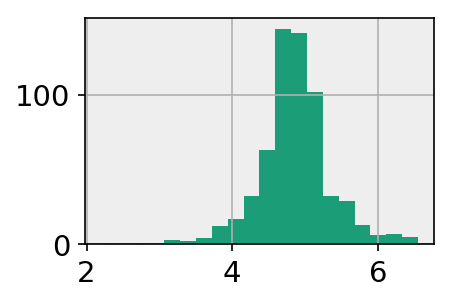

In [35]:
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['TotalIncome_log'] = np.log(train['TotalIncome'])

test['TotalIncome'] = test['ApplicantIncome'] + test['CoapplicantIncome']
test['TotalIncome_log'] = np.log(test['TotalIncome'])

train['LoanAmount_log'].hist(bins=20) 

In [36]:
## Fill missing values for Gender, Male, Dependents, Loan_Amount_Term and Credit_History
# Gender
train['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [37]:
# Since, Male is most frequently occuring, fill missing values as Male
train['Gender'].fillna('Male', inplace=True)

In [38]:
# Repeat for Test data
test['Gender'].value_counts()

Male      286
Female     70
Name: Gender, dtype: int64

In [39]:
# Since, Male is most frequently occuring, fill missing values as Male
test['Gender'].fillna('Male', inplace=True)

In [40]:
# Married
train['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [41]:
train['Married'].fillna('Yes', inplace=True)

In [42]:
test['Married'].value_counts()

Yes    233
No     134
Name: Married, dtype: int64

In [43]:
test['Married'].fillna('Yes', inplace=True)

In [44]:
# Depedents
train['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [45]:
train['Dependents'].fillna('0', inplace=True)

In [46]:
test['Dependents'].value_counts()

0     200
2      59
1      58
3+     40
Name: Dependents, dtype: int64

In [47]:
test['Dependents'].fillna('0', inplace=True)

In [48]:
# Loan_Amount_Term
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [49]:
train['Loan_Amount_Term'].fillna(360, inplace=True)

In [50]:
test['Loan_Amount_Term'].value_counts()

360.0    311
180.0     22
480.0      8
300.0      7
240.0      4
84.0       3
6.0        1
120.0      1
36.0       1
350.0      1
12.0       1
60.0       1
Name: Loan_Amount_Term, dtype: int64

In [51]:
test['Loan_Amount_Term'].fillna(360, inplace=True)

In [52]:
# Credi_History
# Since, Credi History is left blank by user, I am assuming that user does not have a credit history.
train['Credit_History'].fillna(0, inplace=True)
test['Credit_History'].fillna(0, inplace=True)

In [53]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
LoanAmount_log       0
TotalIncome          0
TotalIncome_log      0
dtype: int64

In [54]:
## Now, there are no missing values or outliers in the data.
## Step 3 - Converting Categorical variables into numeric (Because sklearn needs that)

In [55]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [56]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i].astype('str'))
train.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [57]:
test.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
LoanAmount_log       float64
TotalIncome            int64
TotalIncome_log      float64
dtype: object

In [58]:
## Make copy 
test_copy = test.copy()

In [59]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
le = LabelEncoder()
for i in var_mod:
    test[i] = le.fit_transform(test[i].astype('str'))
test.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
LoanAmount_log       float64
TotalIncome            int64
TotalIncome_log      float64
dtype: object

In [60]:
## Step 4 - Build a predictive model
## Logistic Regression

In [61]:
model = linear_model.LogisticRegression()

In [62]:
# So let’s make our first model with ‘Credit_History’
predictors = ['Credit_History', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'TotalIncome_log', 'LoanAmount_log']
outcome_var = 'Loan_Status'
model.fit(train[predictors],train[outcome_var])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
#Make predictions on training set to check accuracy :
predictions = model.predict(train[predictors])

In [64]:
#Print accuracy
accuracy = metrics.accuracy_score(predictions,train[outcome_var])
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 77.036%


In [65]:
#Perform k-fold cross-validation with 5 folds
kf = KFold(train.shape[0], n_folds=5)
error = []
for validation_train, validation_test in kf:
     # Filter training data
    train_predictors = (train[predictors].iloc[validation_train,:])
    
    # The target we're using to train the algorithm.
    train_target = train[outcome_var].iloc[validation_train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(train[predictors].iloc[validation_test,:], train[outcome_var].iloc[validation_test]))
    
print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

#Fit the model again so that it can be refered outside the function:
model.fit(train[predictors],train[outcome_var])

Cross-Validation Score : 77.041%


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
#Make predictions on test set :
predictions = model.predict(test[predictors])

In [67]:
submit

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,N
4,LP001051,Y
5,LP001054,Y
6,LP001055,Y
7,LP001056,N
8,LP001059,Y
9,LP001067,Y


In [68]:
final = test_copy[['Loan_ID']]

In [69]:
final['Loan_Status'] = predictions

C:\Users\jatin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [70]:
final = final.apply(lambda x : x.map({1:'Y', 0: 'N'}))

In [71]:
final['Loan_ID'] = test_copy[['Loan_ID']]

In [72]:
final.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,N
4,LP001051,Y


In [73]:
final.to_csv("Sample_Submission.csv", index=False)